In [1]:
import sys
# sys.path.append('/home/ajhnam/plinko_nn/src')
# sys.path.append('/home/plinkoproj/plinko_nn/src')
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.model.predictor_gru import GRUPredictor_mu
from plinko.misc import plot as plinko_plot

# import matplotlib.pyplot as plt
# from plotnine import *
# %matplotlib inline

In [2]:
# device = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [3]:
# repo_path = '/home/plinkoproj/plinko_nn'
repo_path = '../'
# df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
# df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
# df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

df_ball = pd.read_feather(repo_path + '/data/training/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/training/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/training/sim_collisions.feather')

In [4]:
sim_data = data_utils.get_sim_data(df_ball, df_col)
selected_runs = sim_data[(sim_data.num_collisions == 2)
                         & (sim_data.duration < 80)
                         & (sim_data.run <= 20)]
simulations, environments = data_utils.create_task_df(selected_runs, df_ball, df_env)
states, envs = data_utils.to_tensors(simulations, environments, device)

In [5]:
# print(selected_runs)
# simulations.t.max()
print(df_col)


del df_ball, df_env, df_col

       simulation  run    object   t
0           sim_0    0  pentagon  15
1           sim_0    0    ground  89
2           sim_0    1  pentagon  15
3           sim_0    1  triangle  66
4           sim_0    1    ground  84
...           ...  ...       ...  ..
227639    sim_999   97    ground  62
227640    sim_999   98  triangle  17
227641    sim_999   98    ground  65
227642    sim_999   99  triangle  18
227643    sim_999   99    ground  65

[227644 rows x 4 columns]


In [7]:
def get_logp_loss(gm, targets):
    return -gm.log_p(targets).mean()

def get_mu_mse_loss(gm, targets):
    return F.mse_loss(gm.mu[:,:,0], targets)

In [6]:
# model = GRUPredictor(env_size=11, state_size=2, num_gaussians=2).to(device)
model = GRUPredictor_mu(env_size=11, state_size=2, num_gaussians=1, trainable_h0 = True).to(device)
# optimizer = optim.SGD(model.parameters(), lr=.001)
optimizer = optim.Adam(model.parameters(), lr = 2e-4, weight_decay=.001)
dataset = SimulationDataset(envs, states)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

del envs, states

# print(dataloader)
# print(len(dataset))

# for batch_i, batch in enumerate(dataloader):
#     if batch_i == 0:
#         print(batch_i)
#         print(batch['states'][0])
#         print(batch['targets'][0])


In [42]:
max_t = simulations.t.max()
epochs = 1000
losses = []
mu_overtime = []
sigma_overtime = []
target_overtime = []
# for epoch in tqdm(range(epochs+1)):
for epoch in tqdm(range(601)):
    epoch_loss = 0
    epoch_mse_loss = 0
    epoch_logp_loss = 0
    for batch_i, batch in enumerate(dataloader):
        optimizer.zero_grad()
            
        gm = model(batch['envs'], batch['states'], 0)
        targets = batch['targets']
        
        logp_loss = get_logp_loss(gm, targets)
        mse_loss = 100*get_mu_mse_loss(gm, targets)
        loss = logp_loss + mse_loss
#         loss = mse_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss
        epoch_logp_loss += logp_loss
        epoch_mse_loss += mse_loss
        losses.append((epoch, batch_i, float(loss)))
        
        
        if batch_i == 0:
            gm_mu = gm.mu[:,:,0]
            target_mu = targets
            gm_sigma = gm.sigma[:,:,0]
        
    mu_overtime.append(gm_mu)
    sigma_overtime.append(gm_sigma)
    target_overtime.append(target_mu)    
    
    if epoch%5 == 0:
        print('Epoch {} | logp: {} | mse: {} | total: {}'.format(epoch,
                                                                 round(float(epoch_logp_loss), 4),
                                                                 round(float(epoch_mse_loss), 4),
                                                                 round(float(epoch_loss), 4)))
    
#     if (loss - prev_loss) < .1 and (loss - prev_loss) > -.1:
#         break
    
torch.save(model.state_dict(), 'gru.model')
torch.save(mu_overtime, 'mu_overtime.pt')
torch.save(sigma_overtime, 'sigma_overtime.pt')
torch.save(target_overtime, 'target_overtime.pt')
torch.save(losses, 'losses.pt')

Epoch 0 | logp: 817.3066 | mse: 80685.0391 | total: 81502.3203
Epoch 5 | logp: 2.541 | mse: 428.6926 | total: 431.2336
Epoch 10 | logp: -108.0186 | mse: 120.7637 | total: 12.7451
Epoch 15 | logp: -175.3357 | mse: 60.4734 | total: -114.8623
Epoch 20 | logp: -218.0589 | mse: 35.289 | total: -182.7699
Epoch 25 | logp: -206.8736 | mse: 41.8771 | total: -164.9965
Epoch 30 | logp: -235.5547 | mse: 30.4157 | total: -205.1389
Epoch 35 | logp: -288.6862 | mse: 16.0417 | total: -272.6446
Epoch 40 | logp: -299.1521 | mse: 13.4368 | total: -285.7153
Epoch 45 | logp: -287.1321 | mse: 15.2412 | total: -271.891
Epoch 50 | logp: -249.8357 | mse: 24.4376 | total: -225.3981
Epoch 55 | logp: -276.3468 | mse: 18.044 | total: -258.3028
Epoch 60 | logp: -324.0018 | mse: 9.8946 | total: -314.1071
Epoch 65 | logp: -324.9857 | mse: 9.7412 | total: -315.2444
Epoch 70 | logp: -326.5594 | mse: 9.619 | total: -316.9404
Epoch 75 | logp: -302.8713 | mse: 13.4736 | total: -289.3977
Epoch 80 | logp: -309.3546 | mse: 1

RuntimeError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 11.17 GiB total capacity; 10.26 GiB already allocated; 11.56 MiB free; 583.36 MiB cached)

In [7]:
mu_overtime = torch.load('mu_overtime.pt')
sigma_overtime = torch.load('sigma_overtime.pt')
target_overtime = torch.load('target_overtime.pt')
losses = torch.load('losses.pt')


# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('gru.model'))
model.eval()

GRUPredictor_mu(
  (env_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=32, bias=True)
    )
  )
  (state_embedder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=16, bias=True)
    )
  )
  (gru): GRU(48, 128, num_layers=2)
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=6, bias=True)
    )
  )
)

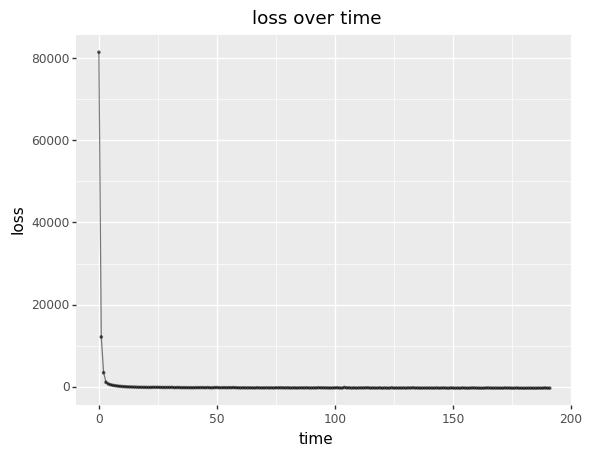

<ggplot: (8729042692813)>


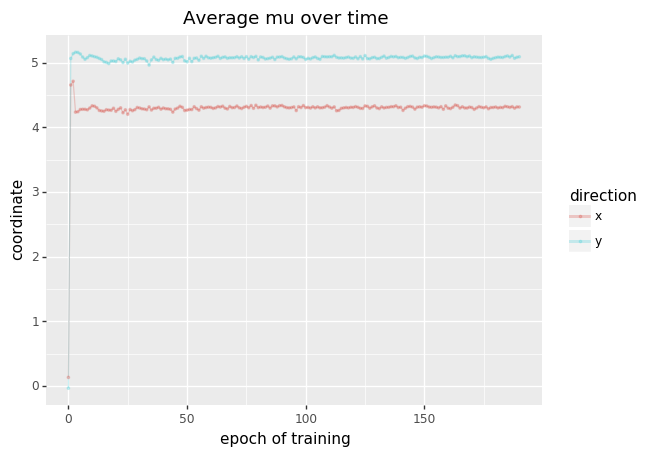

<ggplot: (8729042692409)>


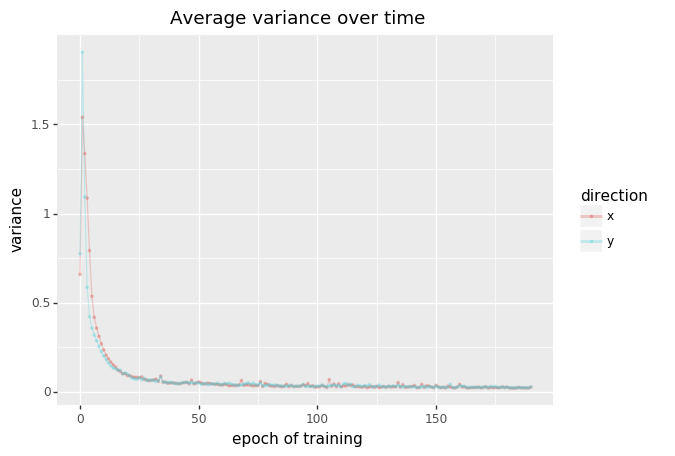

<ggplot: (8729042692785)>


In [43]:
# print(losses)
plinko_plot.plot_losses(losses)
plinko_plot.plot_mu_over_time(mu_overtime)
plinko_plot.plot_variance_over_time(sigma_overtime)

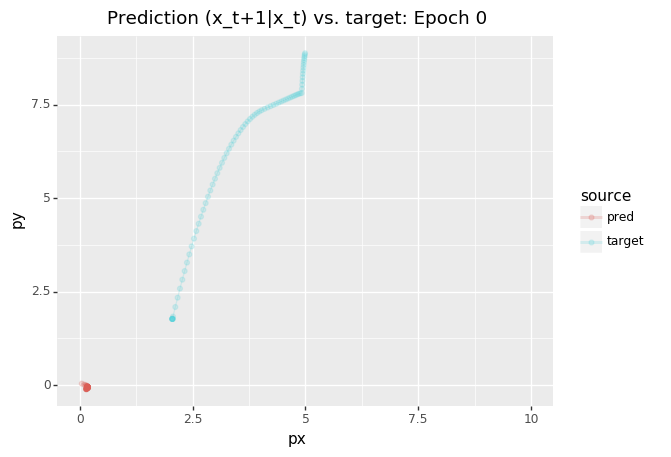

<ggplot: (8729038808153)>


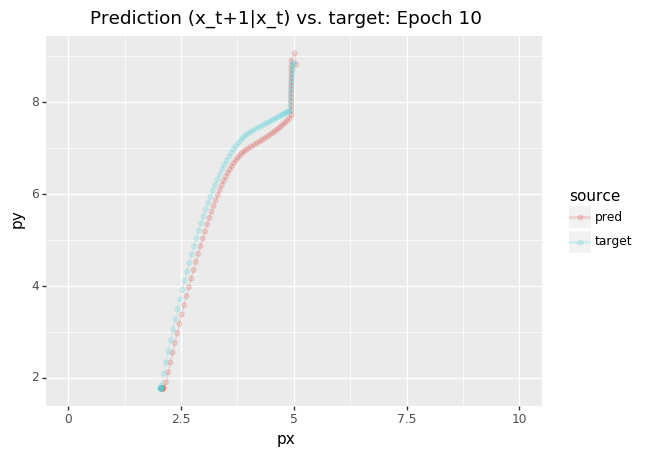

<ggplot: (8729031654149)>


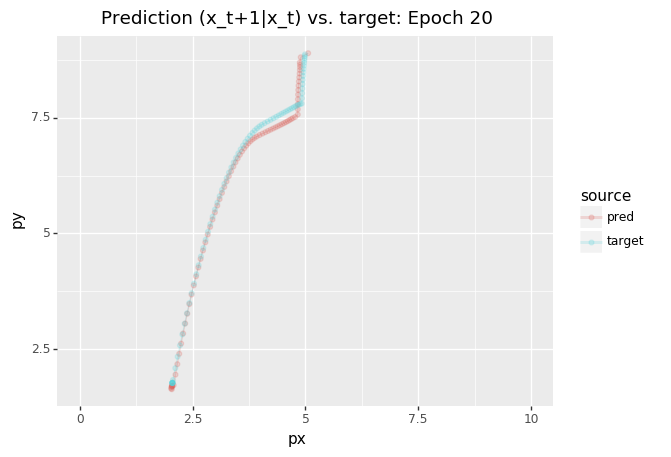

<ggplot: (8729038771417)>


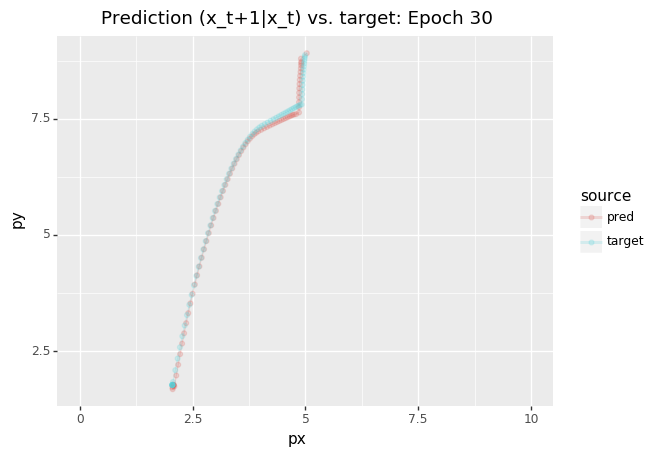

<ggplot: (8729041010305)>


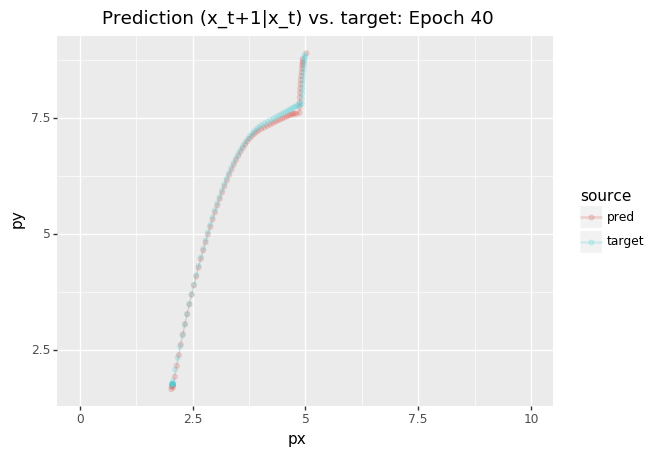

<ggplot: (8729038922545)>


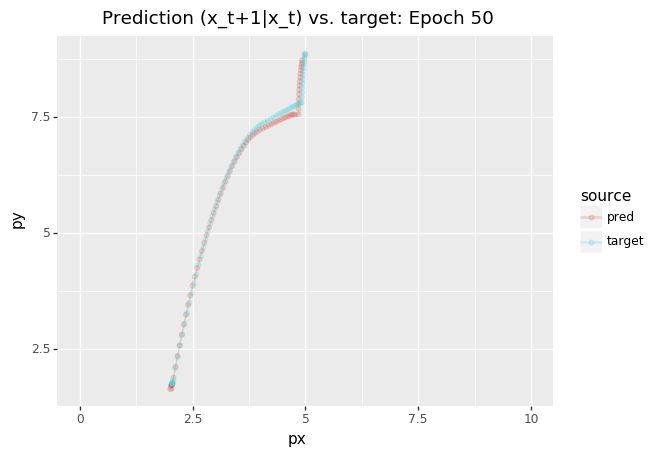

<ggplot: (8729041022073)>


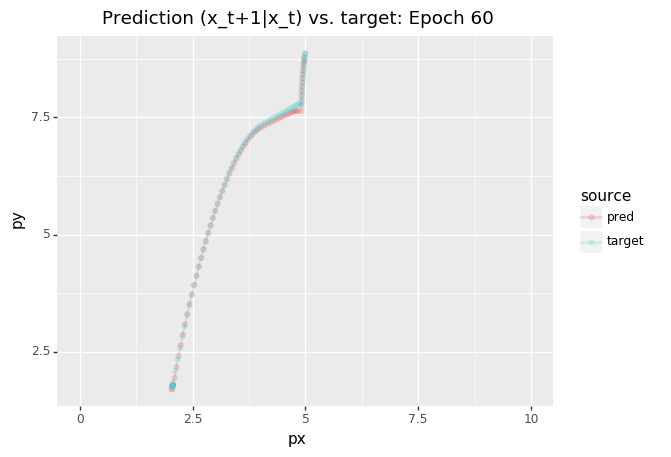

<ggplot: (8729031573229)>


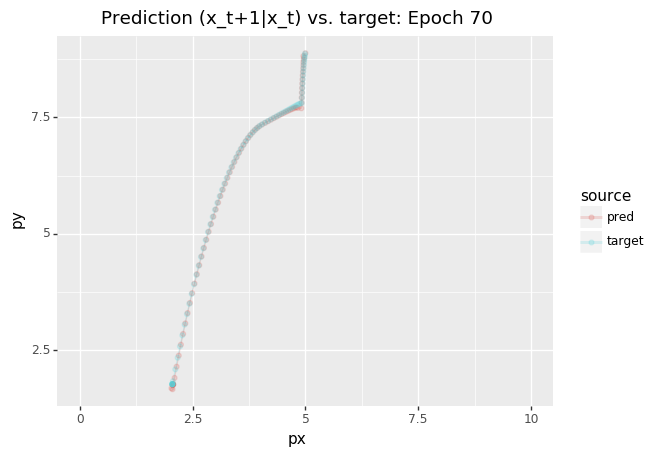

<ggplot: (8729031575521)>


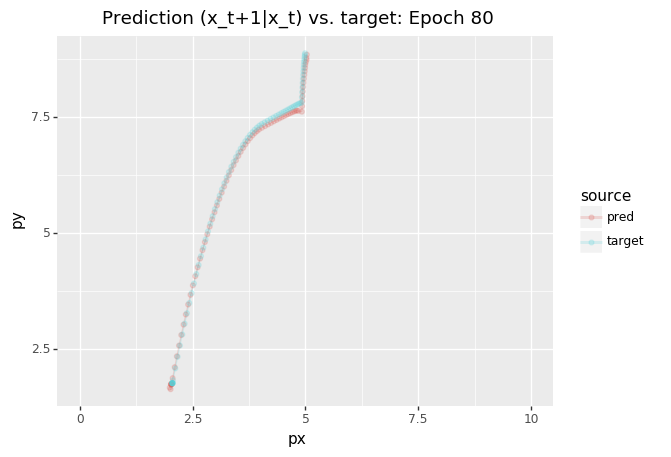

<ggplot: (8729041272217)>


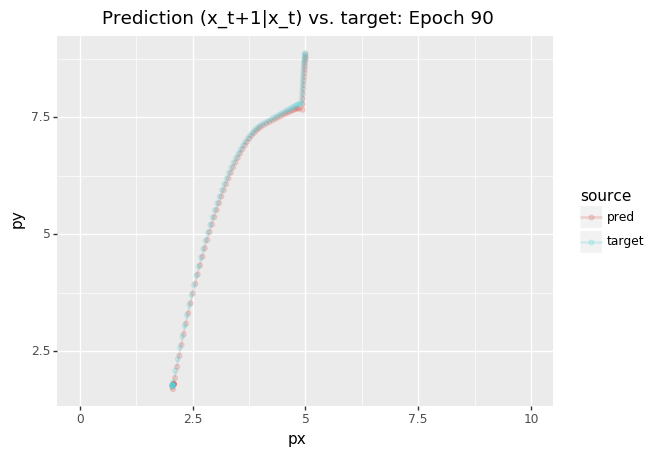

<ggplot: (8729041357133)>


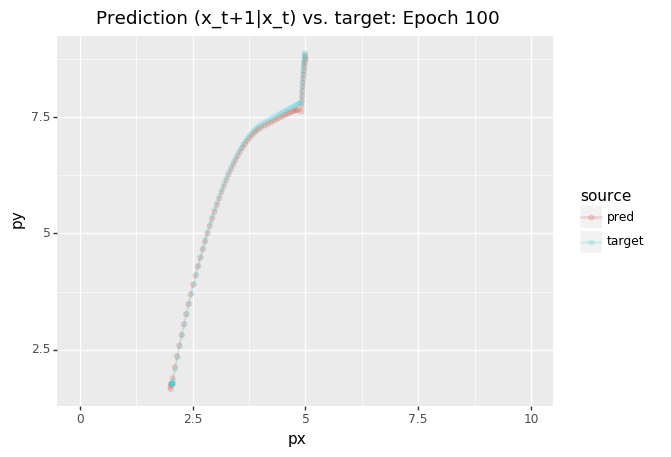

<ggplot: (8729031728005)>


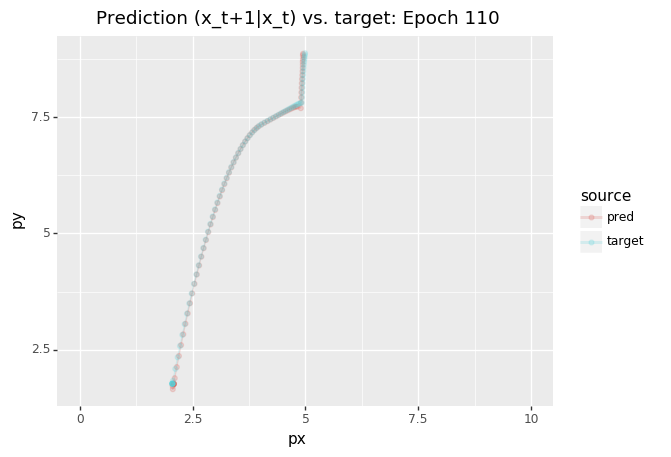

<ggplot: (8729041054141)>


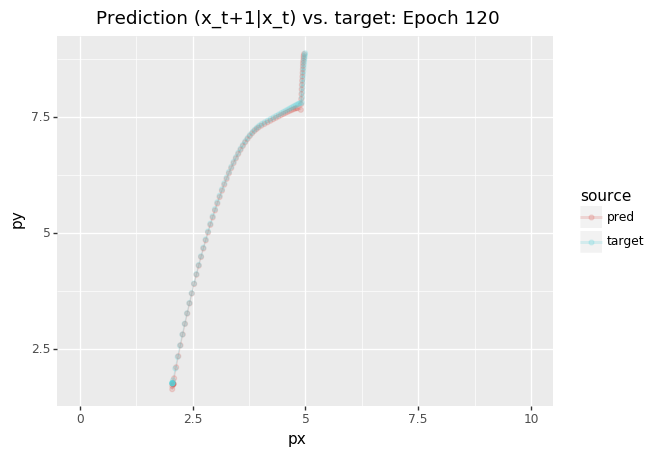

<ggplot: (8729041043277)>


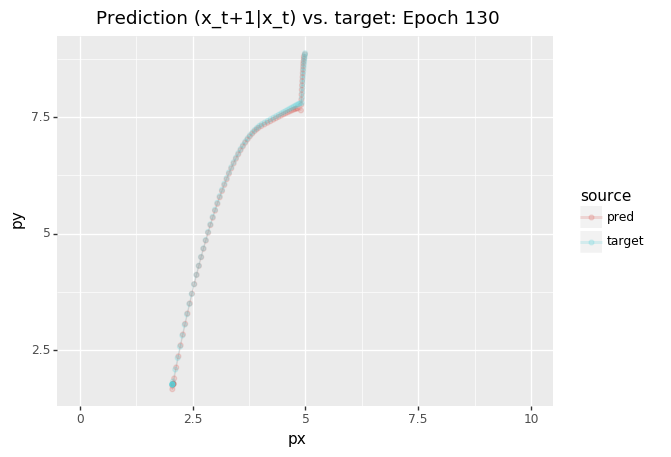

<ggplot: (8729041054141)>


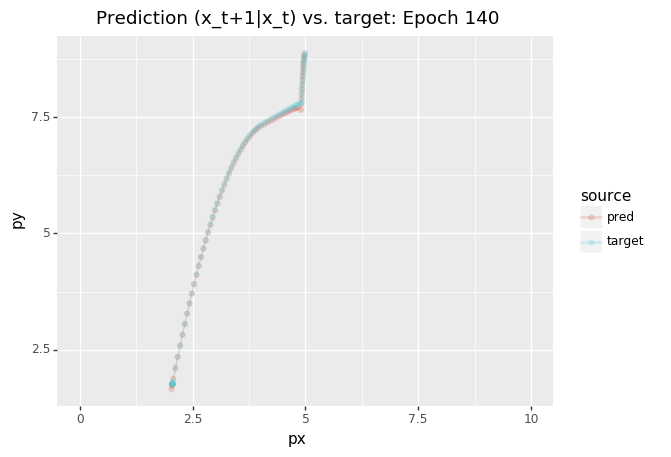

<ggplot: (8729042693625)>


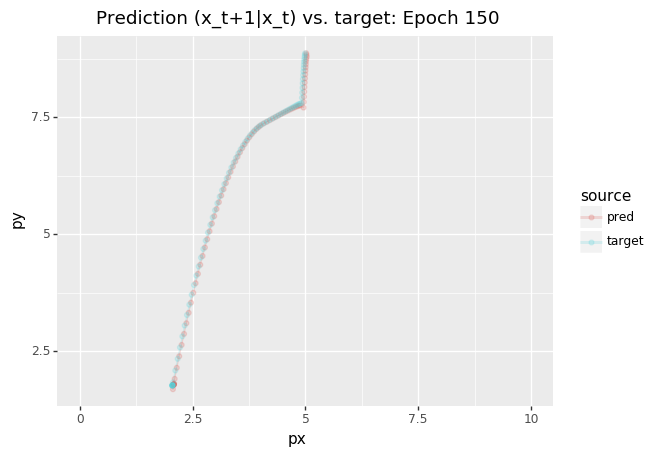

<ggplot: (8729042815365)>


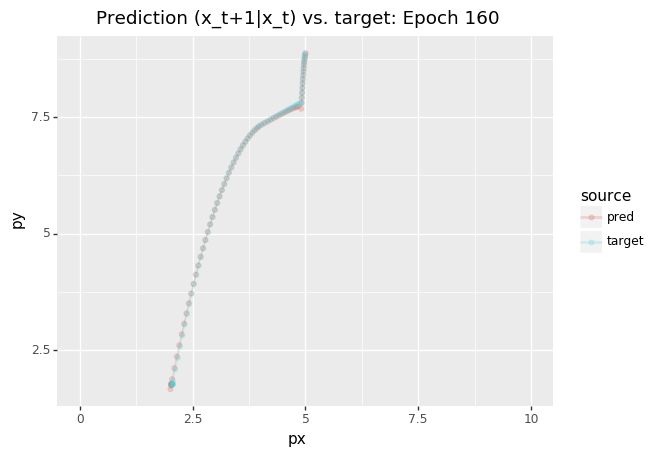

<ggplot: (8729070312229)>


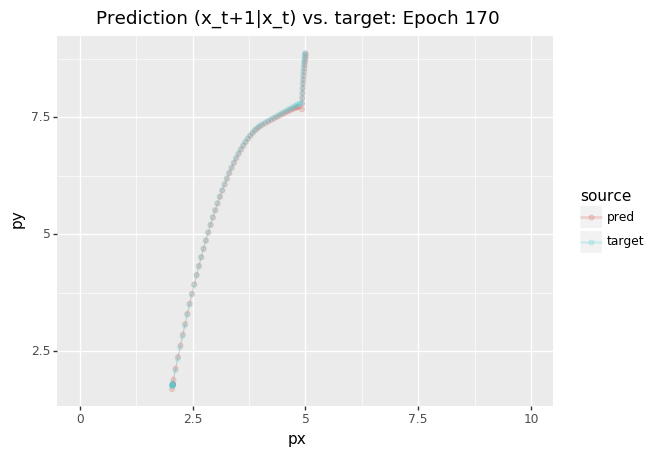

<ggplot: (8729038978761)>


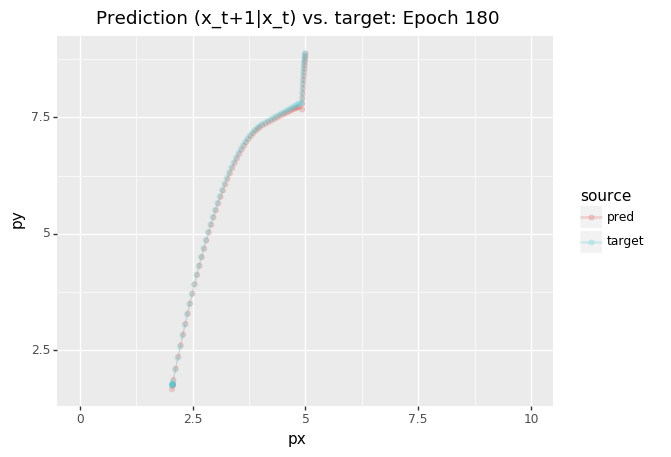

<ggplot: (8729147789441)>


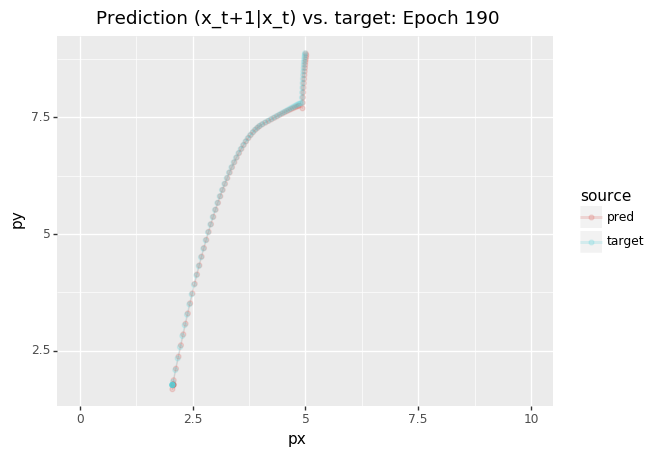

<ggplot: (8729041428889)>


In [46]:
for t in range(len(mu_overtime)):
    if t %10 == 0:
        plinko_plot.plot_pred_target(mu_overtime[t], target_overtime[t], sim_range = range(1),
                                    title = "Prediction (x_t+1|x_t) vs. target: Epoch {}".format(t))

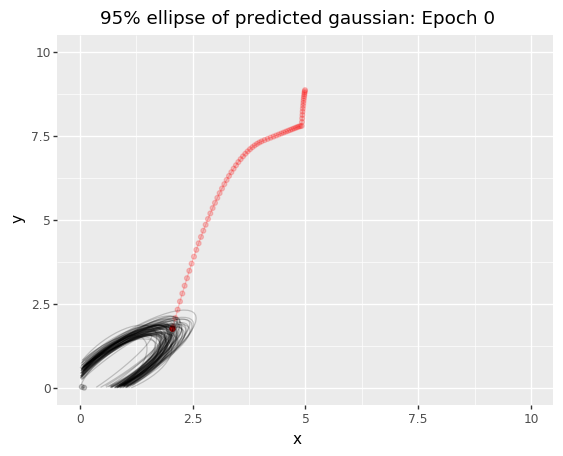

<ggplot: (8729042837245)>


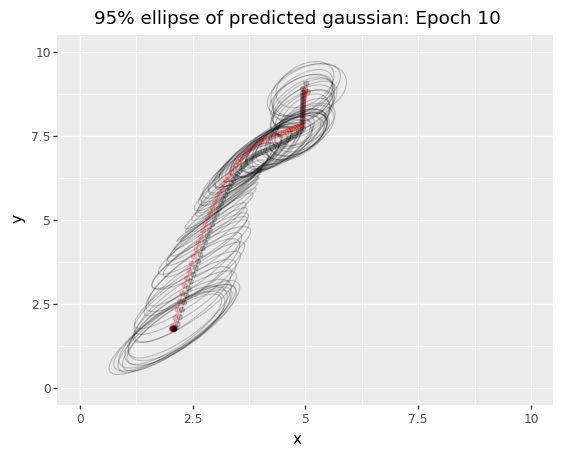

<ggplot: (8729041332033)>


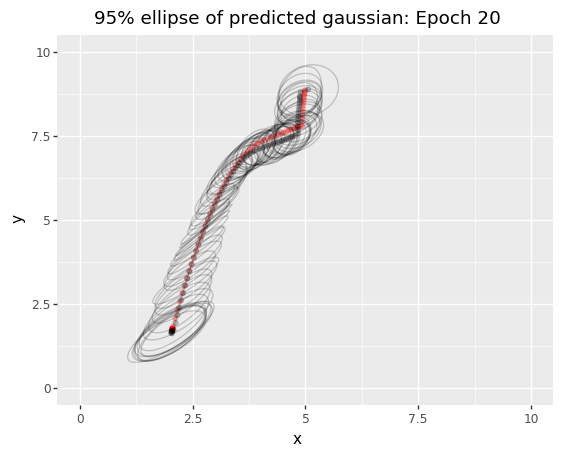

<ggplot: (8729031769553)>


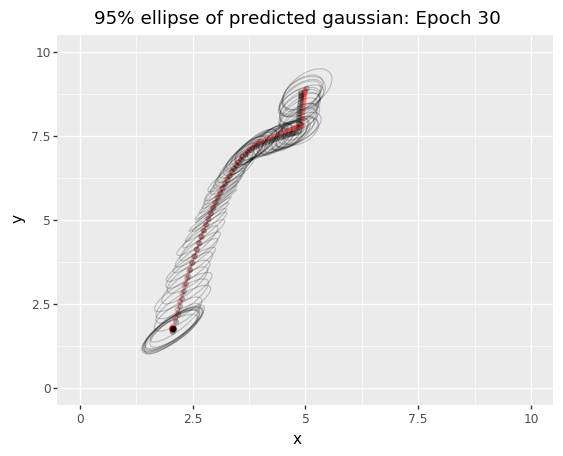

<ggplot: (8729042805873)>


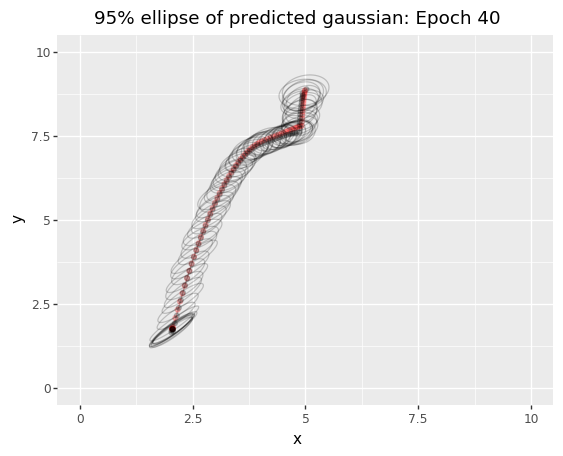

<ggplot: (8729041164437)>


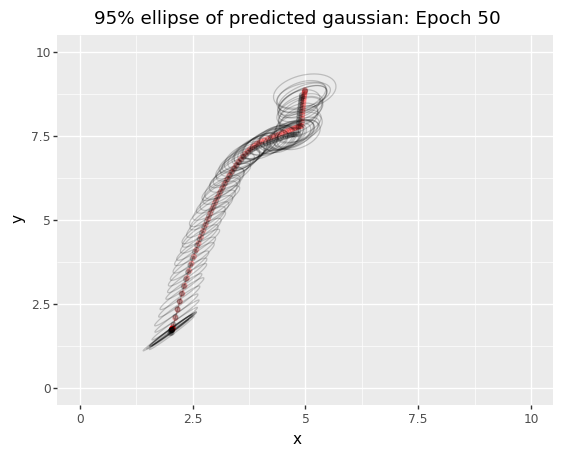

<ggplot: (8729031538697)>


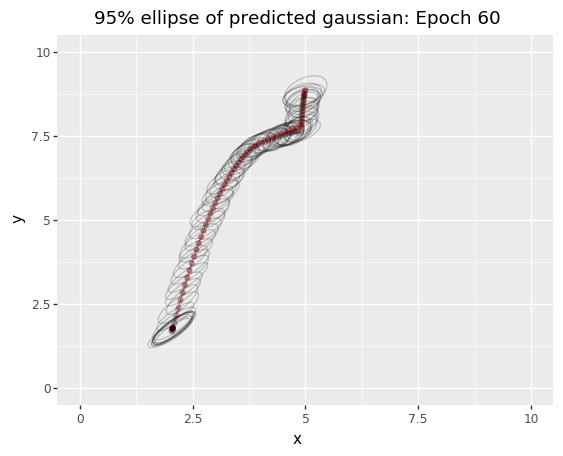

<ggplot: (8729038888881)>


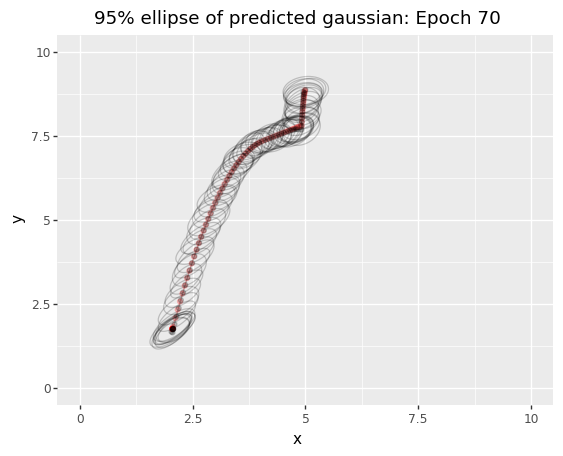

<ggplot: (8729031526233)>


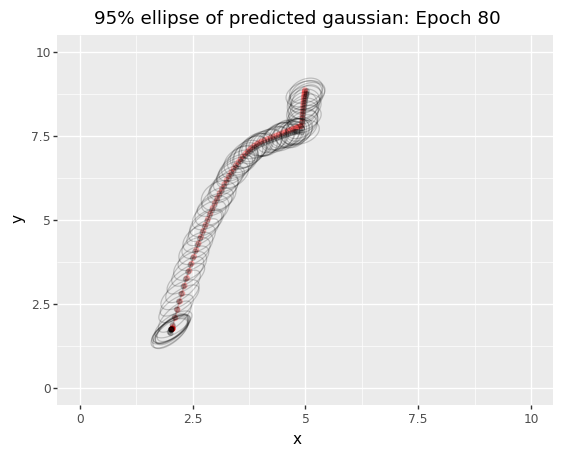

<ggplot: (8729038903277)>


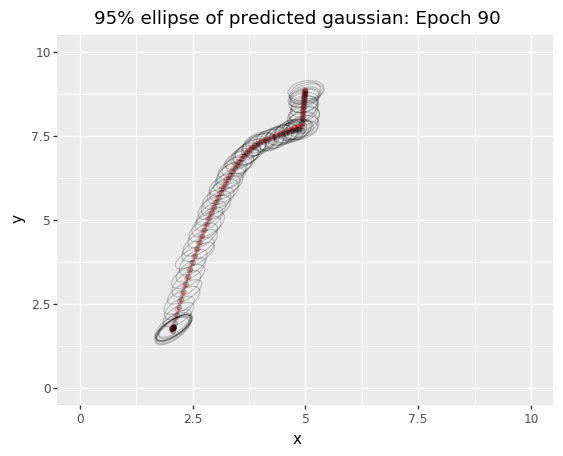

<ggplot: (8729038942485)>


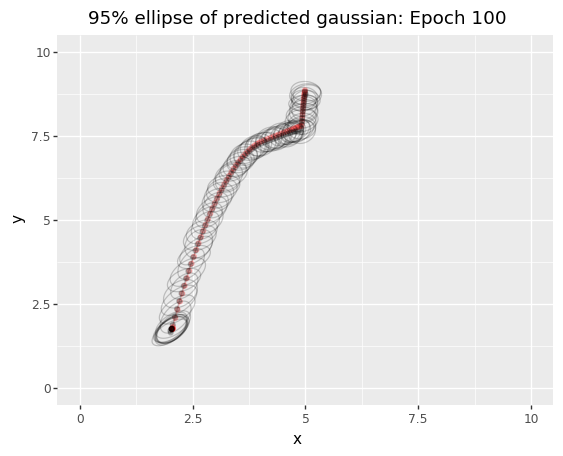

<ggplot: (8729038781265)>


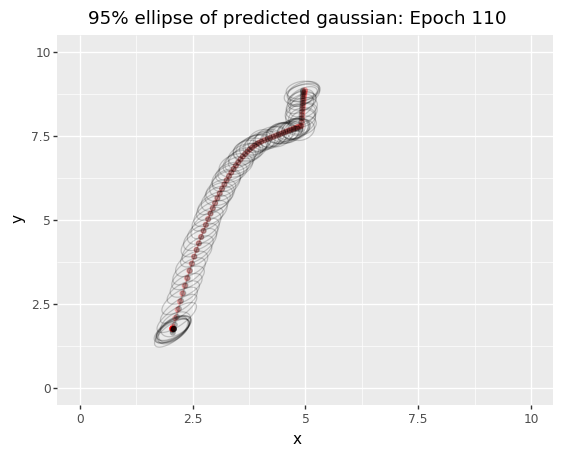

<ggplot: (8729038797097)>


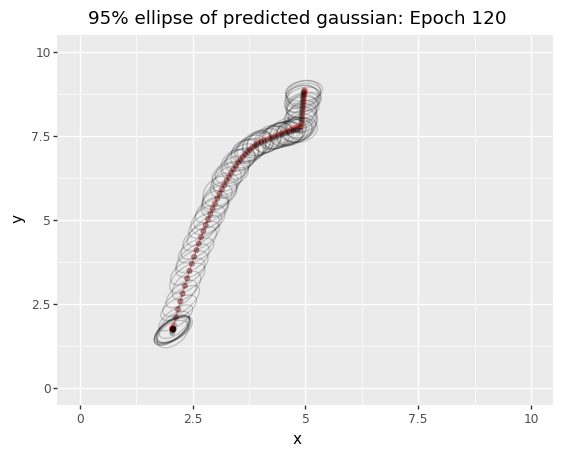

<ggplot: (8729031687737)>


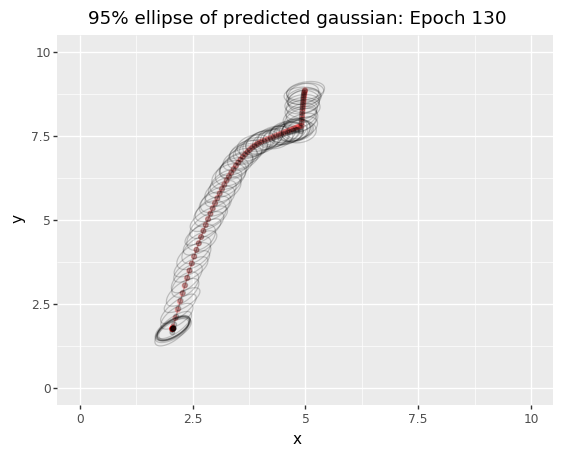

<ggplot: (8729038771677)>


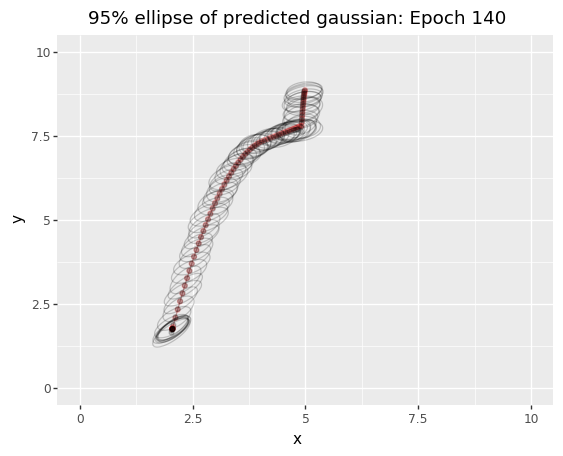

<ggplot: (8729041294917)>


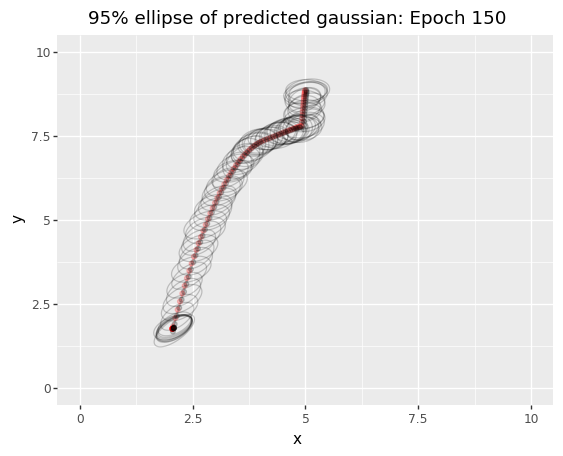

<ggplot: (8729041294197)>


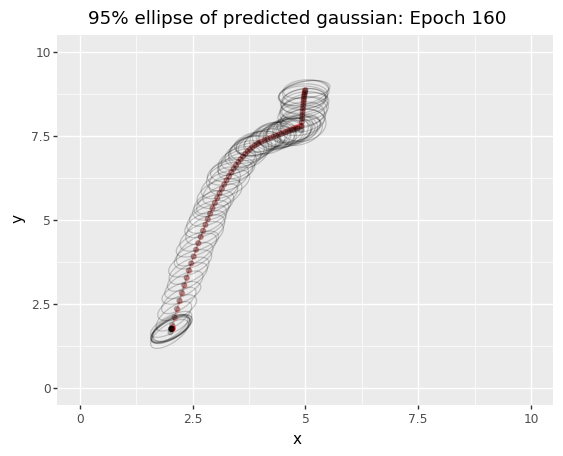

<ggplot: (8729041255157)>


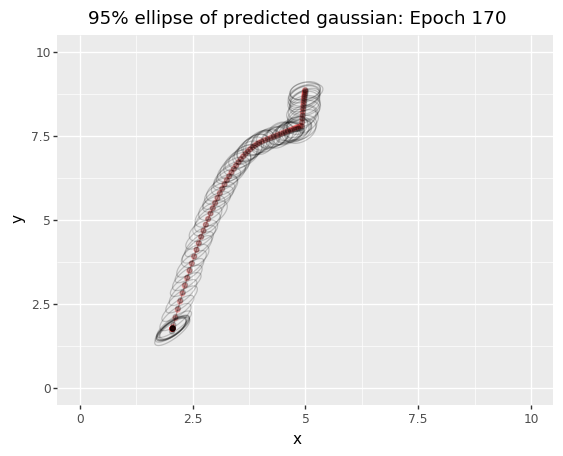

<ggplot: (8729038989121)>


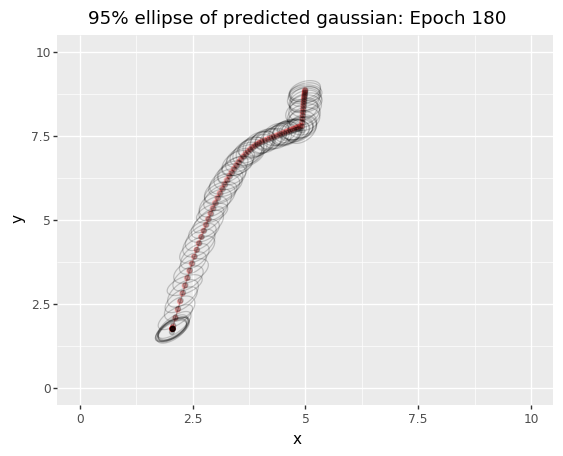

<ggplot: (8729041275313)>


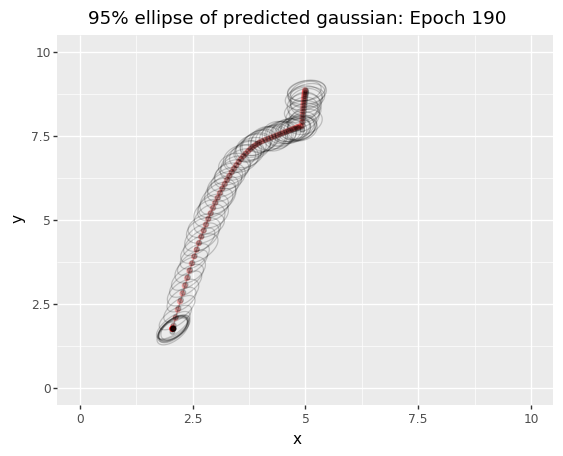

<ggplot: (8729038960001)>


In [45]:
# print(target_overtime[1])

for t in range(len(mu_overtime)):
    if t %10 == 0:
        plinko_plot.plot_pred_gaussian(mu_overtime[t], target_overtime[t], sigma_overtime[t], sim_index = 0, 
                                   title = "95% ellipse of predicted gaussian: Epoch {}".format(t), 
                                       color = 'red', alpha = .2)

In [9]:
def simulate_model(model, dataset, sim_t = 1):
    """
    :sim_t = how many time points to feed in for the simulation
    """
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    i = 0
    for batch in dataloader:
        i += 1
        with torch.no_grad():
            inter_gm, extra_gm, samples = model(batch['envs'], batch['states'][:, 0:sim_t], dataset[0]['states'].shape[0] - sim_t)
            targets = batch['targets'][:,1:101]
#             df_env, df_ball = data_utils.create_simdata_from_samples(samples, batch['envs'],sim_df, env_df)
            
            return samples, targets

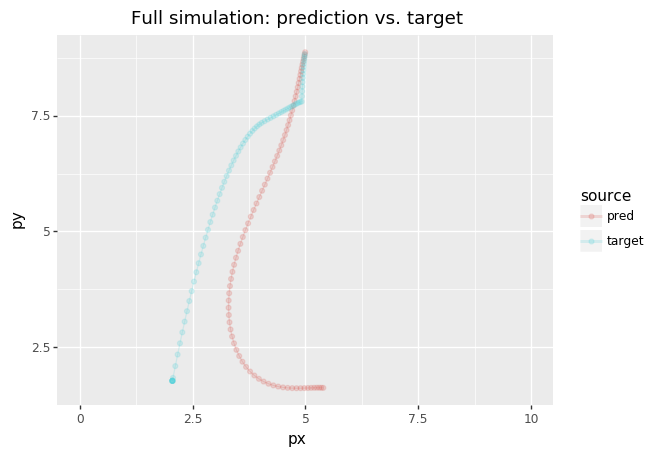

<ggplot: (8727724943357)>


In [10]:
# print(sim_samples.shape)
# print(sim_targets.shape)
# print(gm.mu.shape)

# print(dataset[0]['states'].shape[0])

# simulate from trained model
sim_samples, sim_targets = simulate_model(model, dataset, sim_t = 1)

plinko_plot.plot_pred_target(sim_samples, sim_targets, sim_range=range(1), 
                             title = "Full simulation: prediction vs. target")